Давайте попробуем поизучать сезонность торговых инстументов.
Возьмем, например, EURUSD
Экспортируем из метатрейдера дневной график, он там доступен с ноября 2002 года. 
В принципе, можно экспортировать любой ТФ, но для анализа сезонности нам должно быть достаточно дневных движений
Разметим колонки в файле, как DATE, TIME, OPEN, HIGH, LOW, CLOSE, VOLUME - именно в таком порядке данные расположены в файле выдачи экспорта истории метатрейдера.
Давайте зачитаем его в табличку:

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('EURUSD1440.csv',
                 sep=',',
                 header=0,
                 dtype={
                     'OPEN': np.float64,
                     'HIGH': np.float64,
                     'LOW': np.float64,
                     'CLOSE': np.float64,
                     'VOLUME': np.float64},
                 encoding='utf-8',
                 parse_dates=['DATE'],
                 date_format='%Y.%m.%d').set_index('DATE') 
df.head(5)

,TIME,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,,
2002-11-19,00:00,1.0093,1.0144,1.0005,1.0034,3777.0
2002-11-20,00:00,1.0033,1.0047,0.9988,1.0013,3653.0
2002-11-21,00:00,1.0013,1.0044,0.9977,1.0025,4163.0
2002-11-22,00:00,1.0025,1.0037,0.9958,0.9972,2670.0
2002-11-23,00:00,0.9973,0.9975,0.9800,0.9802,189.0


Нам не очень нужны все эти колонки для анализа.
Все, что нам нужно - это величина тела свечи, положительная для бычьих свечей и отрицательная - для медвежьих.
Для чистоты данных, мы будем считать тело свечи, как разницу между предыдущим и текущим закрытием.
Попутно вычистим неполные годы. Для порядку.

In [7]:
# Calculate the difference between consecutive CLOSE values
df['MOVE'] = df['CLOSE'].diff()
# Handle the first row
df.loc[df.index[0], 'MOVE'] = df.loc[df.index[0], 'CLOSE'] - df.loc[df.index[0], 'OPEN']

# df.drop(columns=['TIME','OPEN','HIGH','LOW','CLOSE', 'VOLUME'], inplace=True)
# Get the start and end years
start_year = df.index[0].year
end_year = df.index[-1].year

# Check if the start date is after January 10th
if df.index[0] > datetime(start_year, 1, 10):
    start_year += 1

# Check if the end date is before December 20th
if df.index[-1] < datetime(end_year, 12, 20):
    end_year -= 1

# Truncate the dataframe
df_trimmed = df[['MOVE']].copy().truncate(before=datetime(start_year, 1, 1), after=datetime(end_year, 12, 31))

df_trimmed.head(5)

,MOVE
DATE,
2003-01-01,-0.0011
2003-01-02,-0.0118
2003-01-03,0.0055
2003-01-06,0.0029
2003-01-07,-0.0036


Стало гораздо приятнее, правда?
Нарисуем это добро на графичке:

<Axes: xlabel='DATE'>

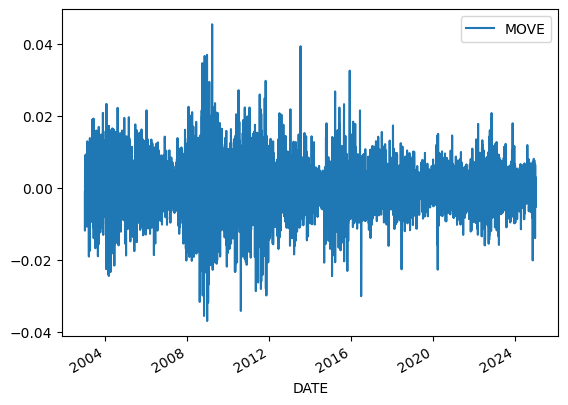

In [8]:
import matplotlib
df_trimmed.plot()

Теперь нам нужно порезать это все на месяцы (чтобы данные одного месяца не сравнивать с данными другого месяца в разные годы, что может случиться за счет разного рода выходных) и сгруппировать по годам:

In [20]:
years = df_trimmed.index.year.unique()
new_index = pd.date_range(start=f'{min(years)}-01-01', end=f'{max(years)}-12-31', freq='D')
df_reindexed = df_trimmed.reindex(new_index).fillna(0.0)
pivot_by_year = df_reindexed.pivot_table(
    index=[df_reindexed.index.month, df_reindexed.index.day],
    columns=df_reindexed.index.year, 
    values='MOVE',
    aggfunc='first').fillna(0.0)  # this fillna is for aligning with leap year
pivot_by_year.head(10)

2003    2004    2005    2006    2007    2008    2009    2010    2011  \
1 1  -0.0011  0.0006  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
  2  -0.0118  0.0020  0.0000 -0.0016  0.0075  0.0098 -0.0050  0.0000 -0.0009   
  3   0.0055  0.0000 -0.0169  0.0216 -0.0102  0.0027  0.0000 -0.0017  0.0000   
  4   0.0000  0.0000 -0.0187  0.0077 -0.0081  0.0008  0.0106  0.0109 -0.0038   
  5   0.0000  0.0100  0.0003 -0.0005 -0.0086  0.0000 -0.0318 -0.0060 -0.0162   
  6   0.0029  0.0036 -0.0099  0.0055  0.0000 -0.0002 -0.0132  0.0037 -0.0177   
  7  -0.0036 -0.0082 -0.0116  0.0000  0.0003 -0.0068  0.0106 -0.0085 -0.0070   
  8   0.0090  0.0134  0.0000 -0.0019  0.0031  0.0025  0.0083  0.0100  0.0000   
  9  -0.0014  0.0068  0.0000 -0.0068 -0.0045 -0.0046 -0.0268  0.0000 -0.0014   
  10  0.0092  0.0000  0.0040 -0.0012 -0.0056  0.0138  0.0000  0.0048  0.0069   

        2012  ...     2015     2016     2017     2018     2019     2020  \
1 1   0.0000  ...  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   
  2  -0.0005  ... -0.00987  0.00000 -0.00138  0.00584 -0.01026 -0.00506   
  3   0.0118  ...  0.00000  0.00000 -0.01016 -0.00439  0.00502 -0.00156   
  4  -0.0124  ...  0.00000 -0.00361  0.00836  0.00529  0.00040  0.00000   
  5  -0.0138  ... -0.00695 -0.00826  0.01162 -0.00380  0.00000  0.00000   
  6  -0.0071  ... -0.00434  0.00333 -0.00738  0.00000  0.00000  0.00397   
  7   0.0000  ... -0.00500  0.01492  0.00000  0.00000  0.00769 -0.00450   
  8  -0.0042  ... -0.00476 -0.00104  0.00000 -0.00620 -0.00331 -0.00478   
  9   0.0093  ...  0.00486  0.00000  0.00404 -0.00306  0.01018  0.00026   
  10 -0.0020  ...  0.00000  0.00000 -0.00180  0.00108 -0.00426  0.00097   

         2021     2022     2023     2024  
1 1   0.00000  0.00000  0.00000  0.00000  
  2   0.00000  0.00000 -0.00454 -0.00955  
  3   0.00000 -0.00873 -0.01089 -0.00193  
  4   0.00353 -0.00103  0.00550  0.00235  
  5   0.00463  0.00252 -0.00821 -0.00054  
  6   0.00278 -0.00137  0.01227  0.00000  
  7  -0.00571  0.00628  0.00000  0.00000  
  8  -0.00493  0.00000  0.00000  0.00094  
  9   0.00000  0.00000  0.00883 -0.00188  
  10  0.00000 -0.00333  0.00012  0.00413  

[10 rows x 22 columns]

<Axes: >

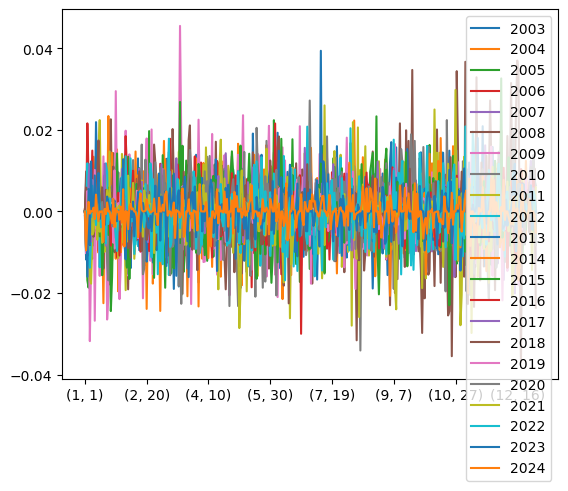

In [21]:
pivot_by_year.plot()

В нашей табличке с пивотом теперь есть колонка с номером месяца и колонка с номером дня месяца - обе входят в индекс - а также колонка для каждого года, в которую записан размер тела свечи с соответствующим знаком в этот день этого месяца этого года.
В целом, данные уже можно проанализировать на корреляцию
Давайте полюбопытствуем


In [40]:
import scipy

correlation_matrix = pivot_by_year.corr()
correlation_matrix.head(50)

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
2003,1.000000,-0.012190,0.015674,-0.050538,-0.071972,0.025652,0.018649,0.035491,-0.013761,-0.001351,...,-0.038025,0.021591,-0.008439,-0.046894,0.001002,0.063584,-0.043407,-0.006342,-0.056562,-0.061196
2004,-0.012190,1.000000,0.007166,-0.002023,-0.047301,-0.045218,-0.112820,0.068638,-0.050316,0.065290,...,0.033436,-0.006134,0.054316,-0.081165,-0.093166,0.030193,-0.106893,-0.024949,0.014916,0.017220
2005,0.015674,0.007166,1.000000,0.002627,0.024869,-0.037652,0.006055,-0.012422,-0.020253,0.012153,...,0.051764,-0.099492,-0.001768,0.046332,0.007878,-0.065424,0.072357,-0.009579,0.010005,0.014846
2006,-0.050538,-0.002023,0.002627,1.000000,-0.008918,0.029153,0.013546,-0.002602,0.033118,-0.003601,...,-0.020145,0.015076,0.056990,-0.027236,-0.009486,-0.000866,0.000199,-0.032686,-0.022628,-0.097038
2007,-0.071972,-0.047301,0.024869,-0.008918,1.000000,0.055141,-0.050794,-0.021321,-0.028642,-0.039534,...,-0.044878,-0.003237,0.044998,0.145394,-0.002566,0.047568,-0.021123,0.004363,0.024582,-0.121907
2008,0.025652,-0.045218,-0.037652,0.029153,0.055141,1.000000,-0.017455,0.013709,-0.047578,0.013813,...,-0.061130,-0.014050,0.028737,0.117181,0.072410,0.027856,-0.086441,0.047613,-0.029639,0.105842
2009,0.018649,-0.112820,0.006055,0.013546,-0.050794,-0.017455,1.000000,0.051796,0.022230,0.009942,...,0.047526,0.034825,0.027995,0.000231,-0.084167,-0.181245,-0.065518,-0.028563,-0.110379,0.023890
2010,0.035491,0.068638,-0.012422,-0.002602,-0.021321,0.013709,0.051796,1.000000,0.027723,0.012321,...,-0.063845,0.090183,-0.025467,-0.050699,-0.047068,0.108444,-0.022423,-0.049631,0.123762,0.030691
2011,-0.013761,-0.050316,-0.020253,0.033118,-0.028642,-0.047578,0.022230,0.027723,1.000000,0.095228,...,-0.008067,-0.051920,0.042392,0.044138,0.047268,0.020619,-0.025316,-0.008156,0.007229,-0.021871
2012,-0.001351,0.065290,0.012153,-0.003601,-0.039534,0.013813,0.009942,0.012321,0.095228,1.000000,...,0.047223,0.058667,0.008609,-0.033795,0.091658,-0.011891,-0.036072,-0.063095,-0.027027,-0.071619


Так, разумеется, ничего не понятно, поэтому мы возьмем верхний треугольник и посчитаем среднюю степень корреляции по годам:

In [41]:
upper_triangle = correlation_matrix.values[np.triu_indices(len(correlation_matrix), k=1)]
average_correlation = np.mean(upper_triangle)
average_correlation

np.float64(0.001425311328268721)

очень близка к нулю, говорит.
Ну мы не удовлетворимся. Обратимся к z-трансформации Фишера, потому что усреднение корреляций - так себе идея

In [42]:
z_values = np.arctanh(upper_triangle)
mean_z = np.mean(z_values)
average_correlation = np.tanh(mean_z)
average_correlation

np.float64(0.0014317653022669682)

Еще хуже. Ну окей, на протяжении всего года корреляция стремится к нулю за последние 20 лет
А давайте, может, поищем интервалы внутри года, где она к нулю не стремится?
<b>Сразу предупрежу: в этот момент мы начинаем подыскивать подтверждение нашей исходной теории после того, как она была опровергнута в целом. Это называется подгонка фактов под теорию, в народе известная, как cherry-picking</b>
<br>
Для начала избавимся от понятия месяц и день - ну не нужны они нам объективно. Просто пронумеруем день в году.

In [38]:
len(pivot_by_year)

366

In [34]:
pivot_reset = pivot_by_year.reset_index(drop=True)
pivot_reset.head(5)

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,-0.0011,0.0006,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,-0.0118,0.0020,0.0000,-0.0016,0.0075,0.0098,-0.0050,0.0000,-0.0009,-0.0005,...,-0.00987,0.00000,-0.00138,0.00584,-0.01026,-0.00506,0.00000,0.00000,-0.00454,-0.00955
2,0.0055,0.0000,-0.0169,0.0216,-0.0102,0.0027,0.0000,-0.0017,0.0000,0.0118,...,0.00000,0.00000,-0.01016,-0.00439,0.00502,-0.00156,0.00000,-0.00873,-0.01089,-0.00193
3,0.0000,0.0000,-0.0187,0.0077,-0.0081,0.0008,0.0106,0.0109,-0.0038,-0.0124,...,0.00000,-0.00361,0.00836,0.00529,0.00040,0.00000,0.00353,-0.00103,0.00550,0.00235
4,0.0000,0.0100,0.0003,-0.0005,-0.0086,0.0000,-0.0318,-0.0060,-0.0162,-0.0138,...,-0.00695,-0.00826,0.01162,-0.00380,0.00000,0.00000,0.00463,0.00252,-0.00821,-0.00054


In [39]:
len(pivot_reset)

366

Определим фитнесс-функцию как среднюю корреляцию суб-матрицы с некоторого одного дня по некоторый другой. По Фишеру.

In [43]:
def fitness_function(df, start_index, end_index):
    # Slice the DataFrame based on the given indices
    df_slice = df.iloc[start_index:end_index+1]
    
    # Calculate the correlation matrix
    corr_matrix = df_slice.corr()
    
    # Extract the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.values[np.triu_indices(len(corr_matrix), k=1)]
        # Apply Fisher's z-transformation
    z_values = np.arctanh(upper_triangle)
    
    # Calculate the mean of z-values
    mean_z = np.mean(z_values)
    
    # Transform back to correlation coefficient
    average_corr = np.tanh(mean_z)
    
    return average_corr

Протестируем нашу фитнес-функцию на уже известной величине: средней корреляции от начала и до конца года

In [44]:
fitness_function(pivot_reset, 0, len(pivot_reset))

np.float64(0.0014317653022669682)

Совпало, отлично. Давайте накрутим оптимизацию, которая выберет нам оптимальные значения индексов?

In [50]:
import pandas as pd
import numpy as np

def find_optimal_intervals(df, fitness_function):
    n = len(df)
    max_interval_size = n // 2
    best_intervals = []
    best_fitness = 0

    for interval_size in range(2, max_interval_size + 1):
        intervals = []
        for start in range(0, n - interval_size + 1):
            end = start + interval_size - 1
            fitness = fitness_function(df, start, end)
            intervals.append((start, end, fitness))
        
        intervals.sort(key=lambda x: x[2], reverse=True)
        selected = []
        
        for interval in intervals:
            if not any(overlaps(interval, selected_interval) for selected_interval in selected):
                selected.append(interval)
        
        avg_fitness = sum(interval[2] for interval in selected) / len(selected)
        if avg_fitness > best_fitness:
            best_fitness = avg_fitness
            best_intervals = selected

    # Convert the best intervals to a DataFrame
    result_df = pd.DataFrame(best_intervals, columns=['Start', 'End', 'Fitness'])
    result_df['Length'] = result_df['End'] - result_df['Start'] + 1
    result_df = result_df.sort_values('Start').reset_index(drop=True)

    return result_df

def overlaps(interval1, interval2):
    return max(interval1[0], interval2[0]) <= min(interval1[1], interval2[1])



Тут, собственно, реализован алгоритм поиска непересекающихся интервалов, жадная вариация.
Он возвращает набор интервалов, отсортированный по убыванию корреляции за все годы.
Натравим его на нашу табличку, попросим :

In [52]:
intervals = find_optimal_intervals(pivot_reset, fitness_function)
# Sort the DataFrame by the 'Fitness' column in descending order
sorted_df = intervals.sort_values('Fitness', ascending=False)
sorted_df.head(10)


,Start,End,Fitness,Length
59,361,365,0.282818,5
16,96,100,0.170004,5
12,75,79,0.133087,5
56,337,341,0.125857,5
2,11,15,0.119404,5
33,202,206,0.116412,5
6,37,41,0.099676,5
40,239,243,0.095892,5
30,185,189,0.084061,5
37,224,228,0.082675,5


Неутешительный итог: даже попытки выдать желаемое за действительное не наловили нам ни одного интервала с корреляцией выше 0.28 за последние 20 лет.
Немного смущает довольно консистентная длительность интервалов - возможно, наши нули, заполняющие промежутки между 